## Analysis of tangling across layers (panel E)

In [1]:
import numpy as np
from functions_notebook import get_layers,measure_tangling
from definitions import ROOT_DIR
import os
import pickle
import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MyoSuite:> Registering Myo Envs


/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8

### A. UMAP
1. __Go to 2. to directly load the previously-obtained data.__\
a. Record trajectories of observations, LSTM, Linear 1, Linear 2 and actions for 3 different masses.\
b. Save the data 

In [3]:
n_mass = 3
configs = [{
    "weighted_reward_keys": {
        "pos_dist_1": 0,
        "pos_dist_2": 0,
        "act_reg": 0,
        "alive": 0,
        "solved": 5,
        "done": 0,
        "sparse": 0
    },
    "enable_rsi": False,
    "rsi_probability": 0,
    "balls_overlap": False,
    "overlap_probability": 0,
    "noise_fingers": 0,
    "limit_init_angle": 3.141592653589793,
    "goal_time_period": [
        5,
        5
    ],
    "goal_xrange": [
        0.025,
        0.025
    ],
    "goal_yrange": [
        0.027,
        0.027
    ],
    "obj_size_range": [
        0.021,
        0.021
    ],
    "obj_mass_range": [
        mass,
        mass
    ],
    "obj_friction_change": [
        0,
        0,
        0
    ],
    "task_choice": "fixed",
    "rotation_direction" : "cw"
} for mass in np.linspace(0.03,0.3,n_mass)]

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"

layers = []
for config in configs : 
    num_ep = 1 # 1 episode per mass, as the configuration is fixed
    layers.append(get_layers(config=config,envir=PATH_TO_NORMALIZED_ENV,env_name=env_name,net=PATH_TO_PRETRAINED_NET,num_ep=num_ep))

'''fp = ""
fp_rollouts = open(fp, 'wb')
pickle.dump(layers,fp_rollouts)
fp_rollouts.close()'''

MyoSuite:> Registering Myo Envs


/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object _last_lstm_states. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


Episode 0
MyoSuite:> Registering Myo Envs
Episode 0
MyoSuite:> Registering Myo Envs
Episode 0


'fp = ""\nfp_rollouts = open(fp, \'wb\')\npickle.dump(layers,fp_rollouts)\nfp_rollouts.close()'

2. Load the trajectories of observations, LSTM, Linear1, Linear2 and actions

In [25]:
# Load the file from Basecamp : 'layers_mass'
layers = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/layers_mass','rb'))
n_mass = 3

3. a. Apply UMAP for each layer (+obs, +acts) across masses\
b. Compute the tangling metric per layer and per mass\
c. Compute the global tangling metric per layer (tangling metric averaged over mass and time)

In [26]:
len_ep1 = len(layers[0])
len_ep2 = len(layers[1])
len_ep3 = len(layers[2])

layers = [item for sublist in layers for item in sublist] # Concatenate all episodes

n_comp = 3
umap_apply = umap.UMAP(n_components=n_comp,random_state=42)

obs = np.array([d['observation'] for d in layers])
obs_trans = umap_apply.fit_transform(obs)
q_obs_ep1 = measure_tangling(obs_trans[0:len_ep1])
q_obs_ep2 = measure_tangling(obs_trans[len_ep1:len_ep1+len_ep2])
q_obs_ep3 = measure_tangling(obs_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_obs = np.mean(np.mean(q_obs_ep1)+np.mean(q_obs_ep2)+np.mean(q_obs_ep3))

lstm = np.array([d['LSTM hidden state'] for d in layers])
lstm_trans = umap_apply.fit_transform(lstm)
q_lstm_ep1 = measure_tangling(lstm_trans[0:len_ep1])
q_lstm_ep2 = measure_tangling(lstm_trans[len_ep1:len_ep1+len_ep2])
q_lstm_ep3 = measure_tangling(lstm_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_lstm = np.mean(np.mean(q_lstm_ep1)+np.mean(q_lstm_ep2)+np.mean(q_lstm_ep3))

l1 = np.array([d['Linear layer 1'] for d in layers])
l1_trans = umap_apply.fit_transform(l1)
q_l1_ep1 = measure_tangling(l1_trans[0:len_ep1])
q_l1_ep2 = measure_tangling(l1_trans[len_ep1:len_ep1+len_ep2])
q_l1_ep3 = measure_tangling(l1_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_l1 = np.mean(np.mean(q_l1_ep1)+np.mean(q_l1_ep2)+np.mean(q_l1_ep3))

l2 = np.array([d['Linear layer 2'] for d in layers])
l2_trans = umap_apply.fit_transform(l2)
q_l2_ep1 = measure_tangling(l2_trans[0:len_ep1])
q_l2_ep2 = measure_tangling(l2_trans[len_ep1:len_ep1+len_ep2])
q_l2_ep3 = measure_tangling(l2_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_l2 = np.mean(np.mean(q_l2_ep1)+np.mean(q_l2_ep2)+np.mean(q_l2_ep3))

acts = np.array([d['actions'] for d in layers])
acts_trans = umap_apply.fit_transform(acts)
q_acts_ep1 = measure_tangling(acts_trans[0:len_ep1])
q_acts_ep2 = measure_tangling(acts_trans[len_ep1:len_ep1+len_ep2])
q_acts_ep3 = measure_tangling(acts_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_acts = np.mean(np.mean(q_acts_ep1)+np.mean(q_acts_ep2)+np.mean(q_acts_ep3))

4. Plot the projected trajectories

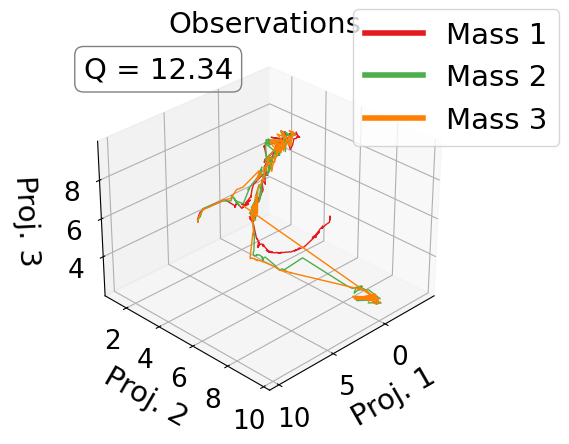

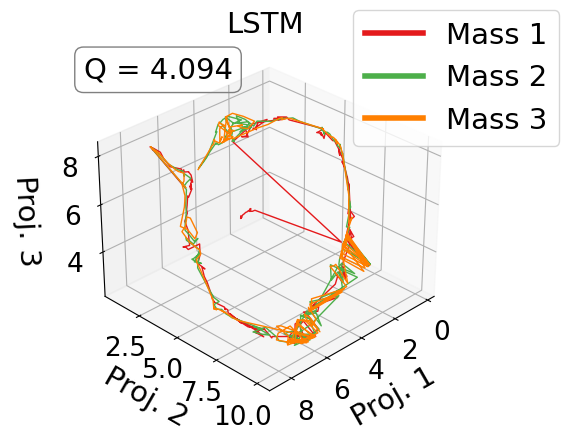

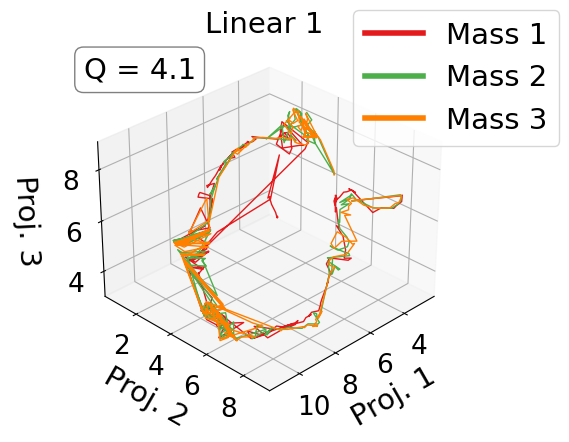

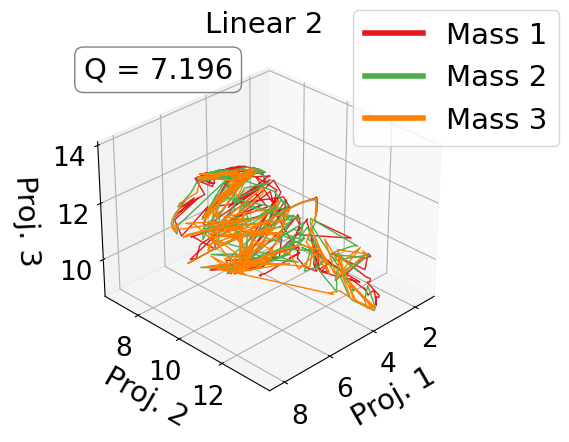

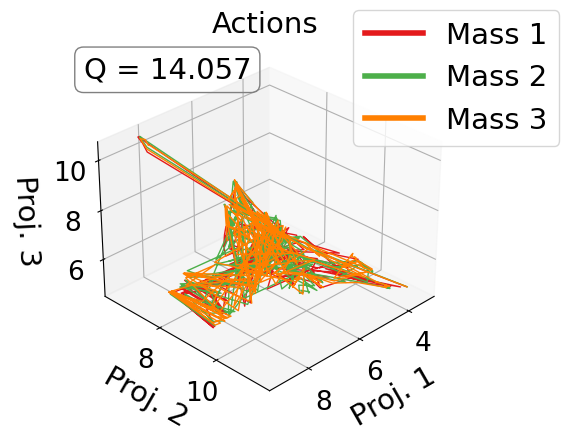

In [27]:
projected_all = [obs_trans,lstm_trans,l1_trans,l2_trans,acts_trans]
filenames = ['obs','lstm','l1','l2','acts']
titles = ['Observations','LSTM','Linear 1','Linear 2','Actions']
Qs = [Q_obs,Q_lstm,Q_l1,Q_l2,Q_acts]

for projected,filename,title,q in zip(projected_all,filenames,titles,Qs):
    eps = [projected[0:len_ep1],projected[len_ep1:len_ep1+len_ep2],projected[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
    cmap = mpl.colormaps['Set1']
    colors = cmap(np.linspace(0,0.5,n_mass))
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i in range(n_mass):
        projected = eps[i]
        ax.plot(projected[:,0],projected[:,1],projected[:,2],color=colors[i],linewidth=1,label='Mass '+str(i+1))

    ax.view_init(elev=30.,azim=45)

    leg = plt.legend(fontsize=21,loc='center left', bbox_to_anchor=(0.7, 0.9))
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    plt.xlabel('Proj. 1',fontsize=21,labelpad=10)
    plt.ylabel('Proj. 2',fontsize=21,labelpad=10)
    ax.set_zlabel('Proj. 3',fontsize=21,labelpad=10)
    plt.title(title,fontsize=21)
    ax.text2D(0.01,0.96, ha='left', va='top', transform=ax.transAxes, s='Q = %s'%np.round(q,3), color='black', 
        bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round',pad=0.3),fontsize=21)
    
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.locator_params(axis='z', nbins=5)
    font = {'size': 19}
    plt.xticks(fontsize=font['size'])
    plt.yticks(fontsize=font['size'])
    ax.tick_params('z', labelsize=font['size'])
    plt.show()

5. Plot the tangling metric for each layer (+obs, +acts) through time

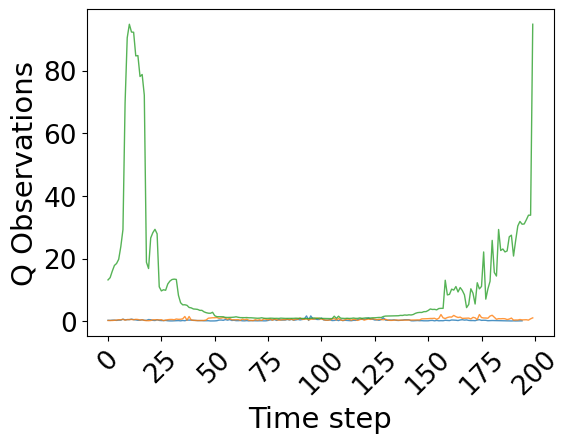

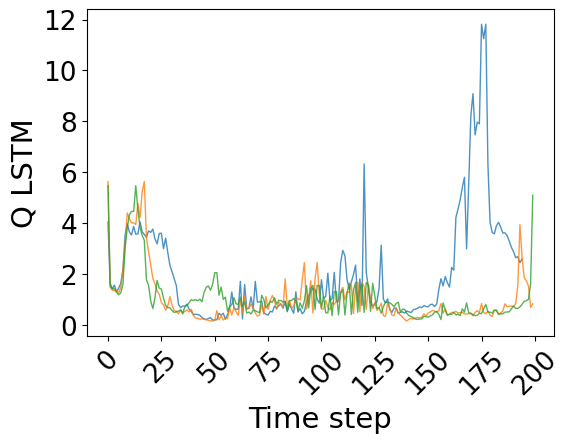

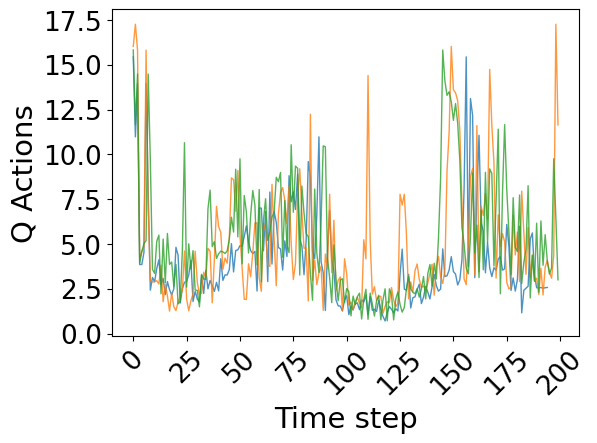

In [29]:
for Qs, title, filename in zip([[q_obs_ep1,q_obs_ep2,q_obs_ep3],[q_lstm_ep1,q_lstm_ep2,q_lstm_ep3],[q_acts_ep1,q_acts_ep2,q_acts_ep3]],['Q Observations','Q LSTM','Q Actions'],['qobs-t','qlstm-t','qacts-t']):
    figure = plt.figure()
    for i in range(len(Qs)) :
        plt.plot(np.arange(0,len(Qs[i]),1),Qs[i],linewidth=1,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Time step',fontsize=21)
    plt.xticks(fontsize=19,rotation=45)
    plt.yticks(fontsize=19)
    plt.subplots_adjust(left=0.17,bottom=0.2)
    plt.show()

6. Compare _a_. Q observations with Q actions and _b_. Q LSTM with Q actions, for all the time instances

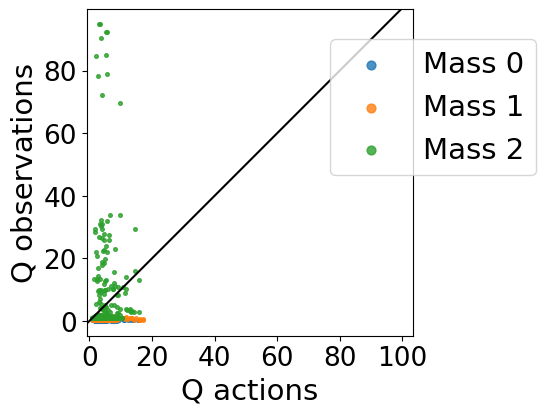

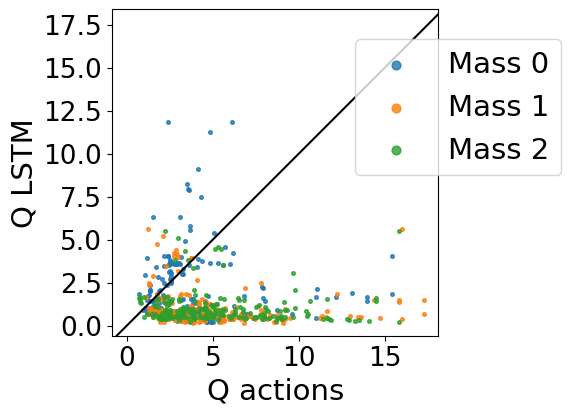

In [8]:
obs_trans_per_mass = [obs_trans[0:len_ep1],obs_trans[len_ep1:len_ep1+len_ep2],obs_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
lstm_trans_per_mass = [lstm_trans[0:len_ep1],lstm_trans[len_ep1:len_ep1+len_ep2],lstm_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
acts_trans_per_mass = [acts_trans[0:len_ep1],acts_trans[len_ep1:len_ep1+len_ep2],acts_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]

for trans,title,filename in zip([obs_trans_per_mass,lstm_trans_per_mass],['Q observations','Q LSTM'],['obs-acts','lstm-acts']):
    figure = plt.figure()
    for i in range(n_mass):
        plt.scatter(measure_tangling(acts_trans_per_mass[i]),measure_tangling(trans[i]),s=7,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Q actions',fontsize=21)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    lgnd = plt.legend(fontsize=21,loc='center left', bbox_to_anchor=(0.7, 0.7))
    lgnd.legendHandles[0]._sizes = [40]
    lgnd.legendHandles[1]._sizes = [40]
    lgnd.legendHandles[2]._sizes = [40]
    plt.subplots_adjust(left=0.15,bottom=0.2)
    pt = (0, 0)
    plt.axline(pt, slope=1, color='black')
    plt.axis('square')
    plt.show()

### B. PCA
1. Load trajectories of observations, LSTM, Linear 1, Linear 2 and actions for 3 different masses (same data as in section A)

In [2]:
# Load the file from Basecamp : 'layers_mass'
layers = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/layers_mass','rb'))
n_mass = 3

3. a. Apply PCA for each layer (+obs, +acts) across masses\
b. Compute the tangling metric per layer and per mass\
c. Compute the global tangling metric per layer (tangling metric averaged over mass and time)\
\
__Remark__. The percentage of explained variance accounted using 25 PCs is :
- 98% for the observations,
- 70% for the LSTM output,
- 87% for the Linear 1 and Linear 2 outputs,
- 94% for the actions.

In [3]:
len_ep1 = len(layers[0])
len_ep2 = len(layers[1])
len_ep3 = len(layers[2])

layers = [item for sublist in layers for item in sublist] 

n_comp = 25
pca = PCA(n_components=n_comp)

obs = np.array([d['observation'] for d in layers])
obs_trans = pca.fit_transform(obs)
q_obs_ep1 = measure_tangling(obs_trans[0:len_ep1])
q_obs_ep2 = measure_tangling(obs_trans[len_ep1:len_ep1+len_ep2])
q_obs_ep3 = measure_tangling(obs_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_obs = np.mean(np.mean(q_obs_ep1)+np.mean(q_obs_ep2)+np.mean(q_obs_ep3))

lstm = np.array([d['LSTM hidden state'] for d in layers])
lstm_trans = pca.fit_transform(lstm)
q_lstm_ep1 = measure_tangling(lstm_trans[0:len_ep1])
q_lstm_ep2 = measure_tangling(lstm_trans[len_ep1:len_ep1+len_ep2])
q_lstm_ep3 = measure_tangling(lstm_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_lstm = np.mean(np.mean(q_lstm_ep1)+np.mean(q_lstm_ep2)+np.mean(q_lstm_ep3))

l1 = np.array([d['Linear layer 1'] for d in layers])
l1_trans = pca.fit_transform(l1)

q_l1_ep1 = measure_tangling(l1_trans[0:len_ep1])
q_l1_ep2 = measure_tangling(l1_trans[len_ep1:len_ep1+len_ep2])
q_l1_ep3 = measure_tangling(l1_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_l1 = np.mean(np.mean(q_l1_ep1)+np.mean(q_l1_ep2)+np.mean(q_l1_ep3))

l2 = np.array([d['Linear layer 2'] for d in layers])
l2_trans = pca.fit_transform(l2)
q_l2_ep1 = measure_tangling(l2_trans[0:len_ep1])
q_l2_ep2 = measure_tangling(l2_trans[len_ep1:len_ep1+len_ep2])
q_l2_ep3 = measure_tangling(l2_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_l2 = np.mean(np.mean(q_l2_ep1)+np.mean(q_l2_ep2)+np.mean(q_l2_ep3))

acts = np.array([d['actions'] for d in layers])
acts_trans = pca.fit_transform(acts)
q_acts_ep1 = measure_tangling(acts_trans[0:len_ep1])
q_acts_ep2 = measure_tangling(acts_trans[len_ep1:len_ep1+len_ep2])
q_acts_ep3 = measure_tangling(acts_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3])
Q_acts = np.mean(np.mean(q_acts_ep1)+np.mean(q_acts_ep2)+np.mean(q_acts_ep3))

4. Plot the tangling metric for each layer (+obs, +acts) through time

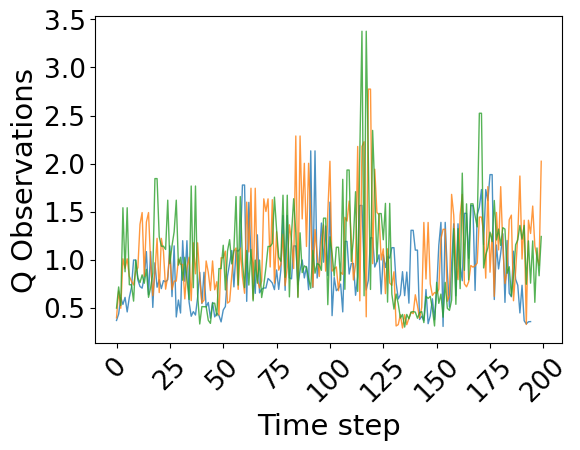

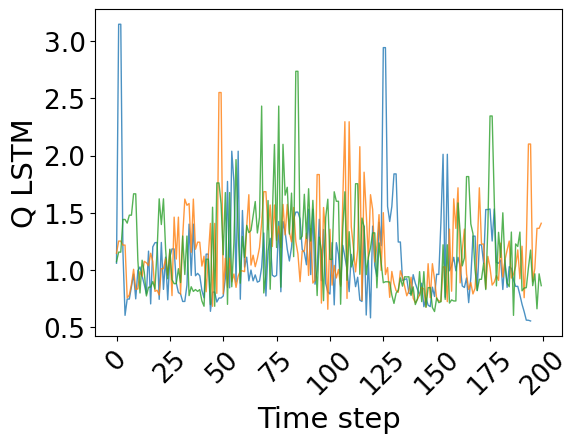

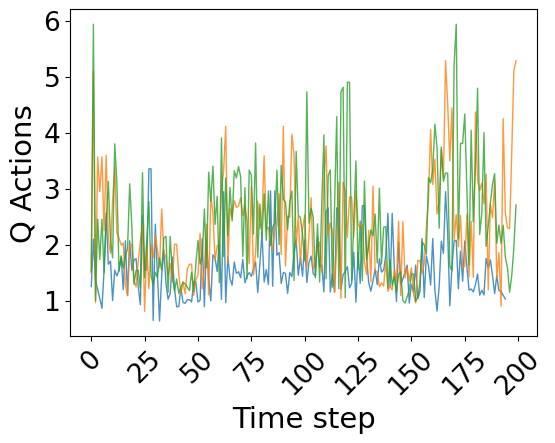

In [34]:
for Qs, title, filename in zip([[q_obs_ep1,q_obs_ep2,q_obs_ep3],[q_lstm_ep1,q_lstm_ep2,q_lstm_ep3],[q_acts_ep1,q_acts_ep2,q_acts_ep3]],['Q Observations','Q LSTM','Q Actions'],['qobs-t','qlstm-t','qacts-t']):
    figure = plt.figure()
    for i in range(len(Qs)) :
        plt.plot(np.arange(0,len(Qs[i]),1),Qs[i],label='Mass %s'%i,linewidth=1,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Time step',fontsize=21)
    plt.xticks(fontsize=19,rotation=45)
    plt.yticks(fontsize=19)
    plt.subplots_adjust(left=0.17,bottom=0.2)
    plt.show()


5. Compare _a_. Q observations with Q actions and _b_. Q LSTM with Q actions, for all the time instances

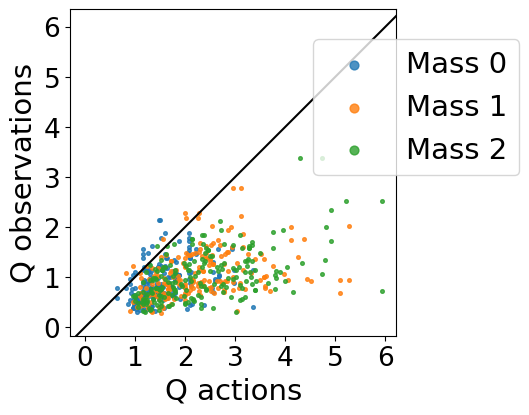

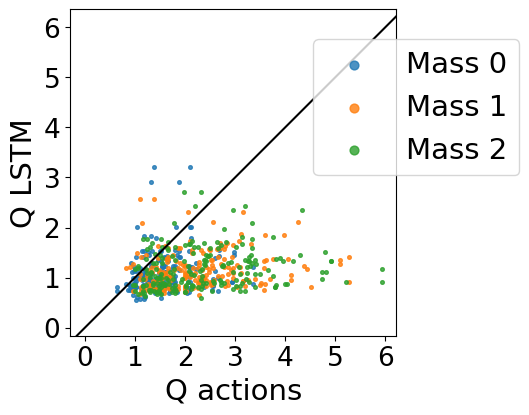

In [12]:
obs_trans_per_mass = [obs_trans[0:len_ep1],obs_trans[len_ep1:len_ep1+len_ep2],obs_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
lstm_trans_per_mass = [lstm_trans[0:len_ep1],lstm_trans[len_ep1:len_ep1+len_ep2],lstm_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]
acts_trans_per_mass = [acts_trans[0:len_ep1],acts_trans[len_ep1:len_ep1+len_ep2],acts_trans[len_ep1+len_ep2:len_ep1+len_ep2+len_ep3]]

for trans, title,filename in zip([obs_trans_per_mass,lstm_trans_per_mass],['Q observations','Q LSTM'],['obs-acts','lstm-acts']):
    figure = plt.figure()
    for i in range(n_mass):
        plt.scatter(measure_tangling(acts_trans_per_mass[i]),measure_tangling(trans[i]),s=7,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Q actions',fontsize=21)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    lgnd = plt.legend(fontsize=21,loc='center left', bbox_to_anchor=(0.7, 0.7))
    lgnd.legendHandles[0]._sizes = [40]
    lgnd.legendHandles[1]._sizes = [40]
    lgnd.legendHandles[2]._sizes = [40]
    plt.subplots_adjust(left=0.15,bottom=0.2)
    pt = (0, 0)
    plt.axline(pt, slope=1, color='black')
    plt.axis('square')
    plt.show()

### C. Full space
1. Load trajectories of observations, LSTM, Linear 1, Linear 2 and actions for 3 different masses (same data as in section A and B)

In [36]:
# Load the file from Basecamp : 'layers_mass'
layers = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/layers_mass','rb'))
n_mass = 3

2. a. Compute the tangling metric per layer and per mass\
b. Compute the global tangling metric per layer (tangling metric averaged over mass and time)\

In [37]:
obs_ep1 = [d['observation'] for d in layers[0]]
obs_ep2 = [d['observation'] for d in layers[1]]
obs_ep3 = [d['observation'] for d in layers[2]]

q_obs_ep1 = measure_tangling(obs_ep1)
q_obs_ep2 = measure_tangling(obs_ep2)
q_obs_ep3 = measure_tangling(obs_ep3)
Q_obs = np.mean(np.mean(q_obs_ep1)+np.mean(q_obs_ep2)+np.mean(q_obs_ep3))

lstm_ep1 = np.array([d['LSTM hidden state'] for d in layers[0]])
lstm_ep2 = np.array([d['LSTM hidden state'] for d in layers[1]])
lstm_ep3 = np.array([d['LSTM hidden state'] for d in layers[2]])

q_lstm_ep1 = measure_tangling(lstm_ep1)
q_lstm_ep2 = measure_tangling(lstm_ep2)
q_lstm_ep3 = measure_tangling(lstm_ep3)
Q_lstm = np.mean(np.mean(q_lstm_ep1)+np.mean(q_lstm_ep2)+np.mean(q_lstm_ep3))

l1_ep1 = np.array([d['Linear layer 1'] for d in layers[0]])
l1_ep2 = np.array([d['Linear layer 1'] for d in layers[1]])
l1_ep3 = np.array([d['Linear layer 1'] for d in layers[2]])

q_l1_ep1 = measure_tangling(l1_ep1)
q_l1_ep2 = measure_tangling(l1_ep2)
q_l1_ep3 = measure_tangling(l1_ep3)
Q_l1 = np.mean(np.mean(q_l1_ep1)+np.mean(q_l1_ep2)+np.mean(q_l1_ep3))

l2_ep1 = np.array([d['Linear layer 2'] for d in layers[0]])
l2_ep2 = np.array([d['Linear layer 2'] for d in layers[1]])
l2_ep3 = np.array([d['Linear layer 2'] for d in layers[2]])

q_l2_ep1 = measure_tangling(l2_ep1)
q_l2_ep2 = measure_tangling(l2_ep2)
q_l2_ep3 = measure_tangling(l2_ep3)
Q_l2 = np.mean(np.mean(q_l2_ep1)+np.mean(q_l2_ep2)+np.mean(q_l2_ep3))

acts_ep1 = np.array([d['actions'] for d in layers[0]])
acts_ep2 = np.array([d['actions'] for d in layers[1]])
acts_ep3 = np.array([d['actions'] for d in layers[2]])

q_acts_ep1 = measure_tangling(acts_ep1)
q_acts_ep2 = measure_tangling(acts_ep2)
q_acts_ep3 = measure_tangling(acts_ep3)
Q_acts = np.mean(np.mean(q_acts_ep1)+np.mean(q_acts_ep2)+np.mean(q_acts_ep3))

3. Plot the tangling metric for each layer (+obs, +acts) through time

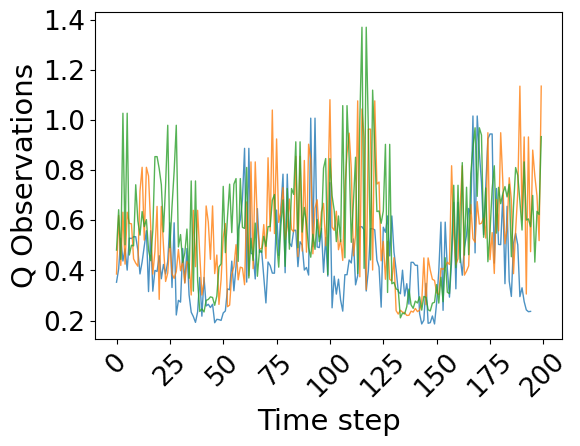

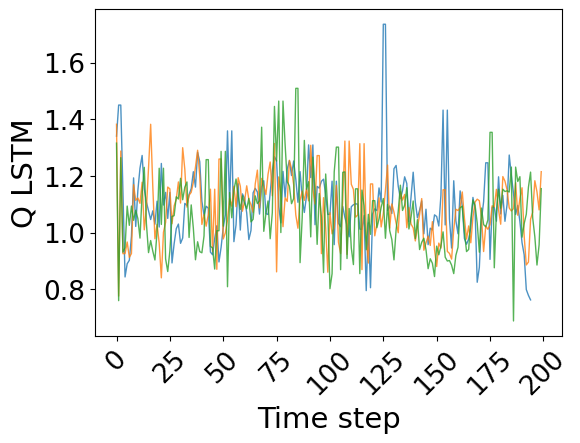

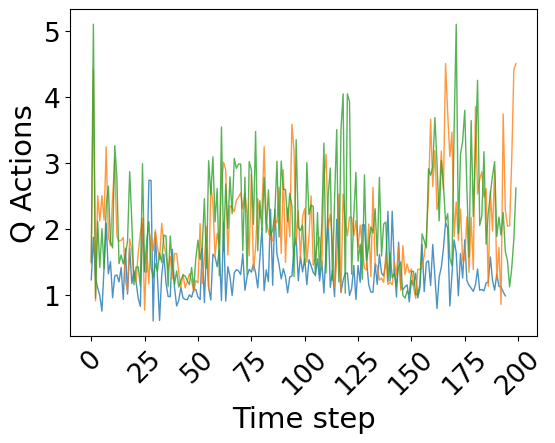

In [38]:
for Qs, title, filename in zip([[q_obs_ep1,q_obs_ep2,q_obs_ep3],[q_lstm_ep1,q_lstm_ep2,q_lstm_ep3],[q_acts_ep1,q_acts_ep2,q_acts_ep3]],['Q Observations','Q LSTM','Q Actions'],['qobs-t','qlstm-t','qacts-t']):
    figure = plt.figure()
    for i in range(len(Qs)) :
        plt.plot(np.arange(0,len(Qs[i]),1),Qs[i],linewidth=1,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Time step',fontsize=21)
    plt.xticks(fontsize=19,rotation=45)
    plt.yticks(fontsize=19)
    plt.subplots_adjust(left=0.17,bottom=0.2)
    plt.show()

4. Compare _a_. Q observations with Q actions and _b_. Q LSTM with Q actions, for all the time instances

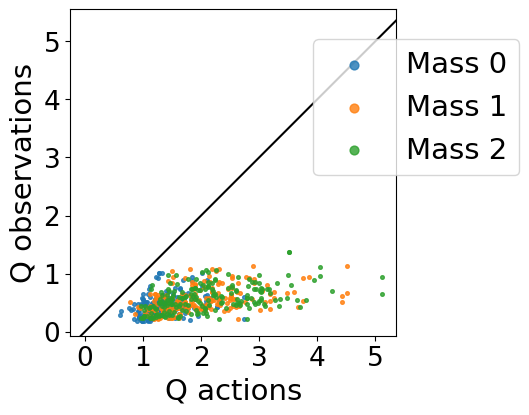

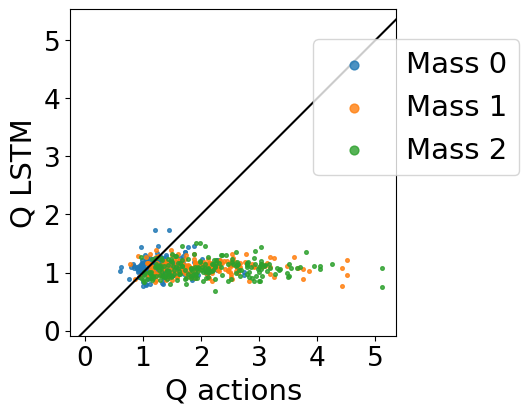

In [16]:
obs_per_mass = [obs_ep1,obs_ep2,obs_ep3]
lstm_per_mass = [lstm_ep1,lstm_ep2,lstm_ep3]
acts_per_mass = [acts_ep1,acts_ep2,acts_ep3]

for trans, title,filename in zip([obs_per_mass,lstm_per_mass],['Q observations','Q LSTM'],['obs-acts','lstm-acts']):
    figure = plt.figure()
    for i in range(n_mass):
        plt.scatter(measure_tangling(acts_per_mass[i]),measure_tangling(trans[i]),s=7,label='Mass %s'%i,alpha=0.8)
    plt.ylabel(title,fontsize=21)
    plt.xlabel('Q actions',fontsize=21)
    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    lgnd = plt.legend(fontsize=21,loc='center left', bbox_to_anchor=(0.7, 0.7))
    lgnd.legendHandles[0]._sizes = [40]
    lgnd.legendHandles[1]._sizes = [40]
    lgnd.legendHandles[2]._sizes = [40]
    plt.subplots_adjust(left=0.15,bottom=0.2)
    pt = (0, 0)
    plt.axline(pt, slope=1, color='black')
    plt.axis('square')
    plt.show()